<a href="https://colab.research.google.com/github/anudeep22003/nlp-training/blob/main/(chapter_9)_Building_Feature_Based_Grammars.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import nltk
from nltk import word_tokenize, re
import matplotlib.pyplot as plt
from pprint import pprint
nltk.download('brown')
nltk.download('treebank')
nltk.download('words')


from nltk.corpus import conll2000
nltk.download('conll2000')

import math 
import random

from nltk.corpus import treebank
nltk.download('treebank')

from collections import defaultdict

nltk.download('ppattach')


nltk.download('book_grammars')

[nltk_data] Downloading package brown to /root/nltk_data...
[nltk_data]   Unzipping corpora/brown.zip.
[nltk_data] Downloading package treebank to /root/nltk_data...
[nltk_data]   Unzipping corpora/treebank.zip.
[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Unzipping corpora/words.zip.
[nltk_data] Downloading package conll2000 to /root/nltk_data...
[nltk_data]   Unzipping corpora/conll2000.zip.
[nltk_data] Downloading package treebank to /root/nltk_data...
[nltk_data]   Package treebank is already up-to-date!
[nltk_data] Downloading package ppattach to /root/nltk_data...
[nltk_data]   Unzipping corpora/ppattach.zip.
[nltk_data] Downloading package book_grammars to /root/nltk_data...
[nltk_data]   Unzipping grammars/book_grammars.zip.


True

Main goals of this chapter:

- How can we extend the framework of context free grammars with features so as to gain more fine-grained control over grammatical categories and productions?
- What are the main formal properties of feature structures and how do we use them computationally?
- What kinds of linguistic patterns and grammatical constructions can we now capture with feature based grammars?


#1. Grammatical Features

>This is a combination of context free grammars from the previous section combined with feature extraction from the supervised learning. 

**Note:** In contrast to the other chapter where we record features that have already been detected (eg: last letter of a name), here we declare features of words and phrases. 

Feature extractors:
- Contain various kinds of information about grammatical entities 
- need not be exhaustive at definition, and can be added to later

The problem with the way we are using features structures is that they are extremely adhoc and need to be stated separately for every new lexical entity that is part of the vocabulary. 

We will look in the next section how we can expand to be able to build a framework that is more generic. 

In [3]:
# these are known as feature structures of the grammar

kim = {
    'CAT': 'NP',        # grammatical category
    'ORTH': 'Kim',      # orthography i.e. spelling 
    'REF': 'kim'          # referent of Kim 
       }

chase = {
    'CAT': 'V',
    'ORTH': 'chased',
    'REL': 'chase'      # relation expressed by the word 
}

lee = {
    'CAT': 'NP',
    'ORTH':'Lee',
    'REF': 'lee'
}

In [4]:
chase['AGT'] = 'subject'      # the agent of the verb

# patient of the object 
# (the semantic role of a noun phrase denoting something that is affected or acted upon by the action of a verb.)
chase['PAT'] = 'object'     

In [20]:
tokens = "Kim chased Lee".split()

# looks through the feature structures we defined, 
# finds a match, returns the dict of the match 
def lex2fs(word):
  for feature_structure in [kim, chase, lee]:
    
    # checking if the word is the word's spelling
    if feature_structure['ORTH'] == word:
      return feature_structure

subj, verb, obj = lex2fs(tokens[0]), lex2fs(tokens[1]), lex2fs(tokens[2])
verb['AGT'] = subj['REF']
verb['PAT'] = obj['REF']

for k,v in verb.items():
  print("%-5s => %s" % (k,v))
print('\n\n')
for k in ['ORTH', 'REL', 'AGT', 'PAT']:
  print("%-5s => %s" % (k, verb[k]))

CAT   => V
ORTH  => chased
REL   => chase
AGT   => kim
PAT   => lee



ORTH  => chased
REL   => chase
AGT   => kim
PAT   => lee


## 1.1. Syntactic Agreement

There is syntactic agreement that comes between verbs and nouns based on whether the noun is singular or plural. 

```
(1)		
a.		this dog
b.		*these dog

(2)		
a.		these dogs
b.		*this dogs
```

A similar kind of covariance holds between subject and predicates

```
(3)		
a.		the dog runs
b.		*the dog run

(4)		
a.		the dogs run
b.		*the dogs runs
```

the covariance between subject and verb is called `agreement`

> One way of capturing these constraints is to encode all the variations into the grammar but this comes at the cost of an exponential increase in the number of production rules. 

Eg: below by adding singular and plural variations, we 2x`d the size. 
If we add another, we increase size 6 times, since we have to do 2*3

In [ ]:
# lets encode the agreement constraints into a CFG 

grammar = nltk.CFG.fromstring("""

  S -> NP VP
  NP -> Det N
  VP -> V

  Det -> 'this'
  N -> 'dog'
  V -> 'runs'

""")

# one way we can add constraints to the production is by hardcoding constraints

grammar = nltk.CFG.fromstring("""

  S -> NP_SG VP_SG
  S -> NP_PL VP_PL
  NP_SG -> Det_SG N_SG
  NP_PL -> Det_PL, N_PL
  VP_SG -> V_SG
  VP_PL -> V_PL

  Det_SG -> 'this'
  DET_PL -> 'these 
  N_SG -> 'dog'
  N_PL -> 'dogs'
  V_SG -> 'run'
  V_PL -> 'runs'

""")

## 1.2. Using Attributes and Constraints 

We shorten the exponential size growth by adding the concept of properties to our linguistic categories 

> Here `[NUM=?n]` is used to enforce conditions on the trees, so that only the value of n chosen by the first condition in the production will be allowed for subsequent. 

### > Storing number independent lexical entries

Certain lexical entries in English are independent of the grammatical number of the objects. Instead of storing them by stating them twice, one can use 

`Det[NUM=?n] -> 'the' | 'some' | 'any'`

In fact we can be even more economical and **skip mention of the number** completely

`Det -> 'the' | 'some' | 'any'`

> You can have any number of features 

`VP[Tense=pres, NUM=PL] -> 'disappear' | 'walk'`

> The rules are binded as dictionary values. So the values of `{?n: 'sg', ?t" 'pres'}` are stored like a dictionary 

In [ ]:
grammar_attributed = nltk.CFG.fromstring("""

  S -> NP[NUM=?n] VP[NUM=?n]                  # here ?n means the value of n will be enforced when building trees
  NP[NUM=?n] -> Det[NUM=?n] N[NUM=?n]
  VP[NUM=?n] -> v[NUM=?n]

  N[NUM=sg] -> 'this'
  Det[NUM=pl] -> 'these'
  Det[NUM = SG] -> 'this'
  N[NUM=sg] -> 'dog'
  N[NUM=pl] -> 'dogs'
  V[NUM=sg] -> 'runs'
  V[NUM=pl] -> 'run'

""")

In [33]:
# a combination of some of the features attributes
nltk.download('book_grammars')
nltk.data.show_cfg('grammars/book_grammars/feat0.fcfg')


[nltk_data] Downloading package book_grammars to /root/nltk_data...
[nltk_data]   Package book_grammars is already up-to-date!
% start S
# ###################
# Grammar Productions
# ###################
# S expansion productions
S -> NP[NUM=?n] VP[NUM=?n]
# NP expansion productions
NP[NUM=?n] -> N[NUM=?n] 
NP[NUM=?n] -> PropN[NUM=?n] 
NP[NUM=?n] -> Det[NUM=?n] N[NUM=?n]
NP[NUM=pl] -> N[NUM=pl] 
# VP expansion productions
VP[TENSE=?t, NUM=?n] -> IV[TENSE=?t, NUM=?n]
VP[TENSE=?t, NUM=?n] -> TV[TENSE=?t, NUM=?n] NP
# ###################
# Lexical Productions
# ###################
Det[NUM=sg] -> 'this' | 'every'
Det[NUM=pl] -> 'these' | 'all'
Det -> 'the' | 'some' | 'several'
PropN[NUM=sg]-> 'Kim' | 'Jody'
N[NUM=sg] -> 'dog' | 'girl' | 'car' | 'child'
N[NUM=pl] -> 'dogs' | 'girls' | 'cars' | 'children' 
IV[TENSE=pres,  NUM=sg] -> 'disappears' | 'walks'
TV[TENSE=pres, NUM=sg] -> 'sees' | 'likes'
IV[TENSE=pres,  NUM=pl] -> 'disappear' | 'walk'
TV[TENSE=pres, NUM=pl] -> 'see' | 'like'
IV[TENS

In [9]:
from nltk import load_parser 
cp = load_parser("grammars/book_grammars/feat0.fcfg", trace=2)

sent = "the dogs like the girls".split()

for tree in cp.parse(sent):
  print(tree)

|.th.do.li.th.gi.|
Leaf Init Rule:
|[--]  .  .  .  .| [0:1] 'the'
|.  [--]  .  .  .| [1:2] 'dogs'
|.  .  [--]  .  .| [2:3] 'like'
|.  .  .  [--]  .| [3:4] 'the'
|.  .  .  .  [--]| [4:5] 'girls'
Feature Bottom Up Predict Combine Rule:
|[--]  .  .  .  .| [0:1] Det[] -> 'the' *
Feature Bottom Up Predict Combine Rule:
|[-->  .  .  .  .| [0:1] NP[NUM=?n] -> Det[NUM=?n] * N[NUM=?n] {}
Feature Bottom Up Predict Combine Rule:
|.  [--]  .  .  .| [1:2] N[NUM='pl'] -> 'dogs' *
Feature Bottom Up Predict Combine Rule:
|.  [--]  .  .  .| [1:2] NP[NUM='pl'] -> N[NUM='pl'] *
Feature Single Edge Fundamental Rule:
|[-----]  .  .  .| [0:2] NP[NUM='pl'] -> Det[NUM='pl'] N[NUM='pl'] *
Feature Bottom Up Predict Combine Rule:
|[----->  .  .  .| [0:2] S[] -> NP[NUM=?n] * VP[NUM=?n] {?n: 'pl'}
Feature Bottom Up Predict Combine Rule:
|.  [-->  .  .  .| [1:2] S[] -> NP[NUM=?n] * VP[NUM=?n] {?n: 'pl'}
Feature Bottom Up Predict Combine Rule:
|.  .  [--]  .  .| [2:3] TV[NUM='pl', TENSE='pres'] -> 'like' *
Feature B

## 1.3 Terminology

So far we have had mostly single or group features. Single features are called **atomic**, in the sense they cannot be broken down further.  Features can be extended to include **Boolean features** as well as **bundle of features**

--- 
**Example of Boolean:**

>In the below, certain words have the auxilliary boolean `True` or `False` that means they are verbs that can take on an auxilliary character, compared to walks and likes which are also verbs but cannot take on an auxilliary character. 

```
V[TENSE=pres, +AUX] -> 'can'
V[TENSE=pres, +AUX] -> 'may'

V[TENSE=pres, -AUX] -> 'walks'
V[TENSE=pres, -AUX] -> 'likes'
````
---

**Example of bundle of features**

>Here the AGR value is a bundle of features. The format used below is called an `Attribute Value Matrix`

```
[POS = N             ]
[                    ]
[AGR = [PER = 3]     ]
[      [NUM = pl]    ]
[      [ GND = F]    ]
```

Hence we refactor a grammar to account for higher attribute specificity as so:

```
S                                      -> NP[AGR=?n] VP[AGR=?n]
NP[AGR=?n]                             -> PropN[AGR=?n]
VP[TENSE=?t, AGR=?n]                   -> Cop[TENSE=?t, AGR=?n] Adj

Cop[TENSE=pres, AGR=[NUM=sg, PER=3]]   -> 'is'
PropN[AGR=[NUM=sg, PER=3]]             -> 'Kim'
Adj                                    -> 'happy'

```

# Processing Feature Extractors

- Atomic feature values can be strings or integers
- Features are declared using the `FeatStruct()` constructor.
 - Feature structures are just a kind of dictionary, and hence can be accessed through similar indexing
  - features dont need to be only of linguistic type, it can be used to reprsent any kind of knowledge (precursor to Knowledge Graphs) 

In [15]:
# simple feature structure
fs1 = nltk.FeatStruct(TENSE='past', NUM = 'sg')
print(fs1, end = '\n\n')

# indexing a feature structure
print(fs1['NUM'])

# complicated bundle of features 
fs2 = nltk.FeatStruct(POS = 'N', AGR = fs1)
print(fs2, end = '\n\n')
print(fs2.items(), end = '\n---------------\n')
print(fs2['AGR']['TENSE'], "--> multilevel indexing is required to access nested feature structure", end = '\n---------------\n')


# features don't need to be only linguistic, can represent general knowledge
fs3 = nltk.FeatStruct(Phone = '4155833624', DOB = '12/05/1989', INTEREST = 'NLP') 
fs4 = nltk.FeatStruct(OG = fs2, KG = fs3)

print(fs4)

[ NUM   = 'sg'   ]
[ TENSE = 'past' ]

sg
[ AGR = [ NUM   = 'sg'   ] ]
[       [ TENSE = 'past' ] ]
[                          ]
[ POS = 'N'                ]

dict_items([('POS', 'N'), ('AGR', [NUM='sg', TENSE='past'])])
---------------
past --> multilevel indexing is required to access nested feature structure
---------------
[      [ DOB      = '12/05/1989' ]  ]
[ KG = [ INTEREST = 'NLP'        ]  ]
[      [ Phone    = '4155833624' ]  ]
[                                   ]
[      [ AGR = [ NUM   = 'sg'   ] ] ]
[ OG = [       [ TENSE = 'past' ] ] ]
[      [                          ] ]
[      [ POS = 'N'                ] ]


# Directed Acyclic graphs

>It is often helpful to see feature structures as graphs, specifically `Directed Acyclic Graphs`

- Feature names are labels on the directed arc
- Feature values appear as labels on the nodes pointe to by the directed graph
- **Feature paths** are defined as the sequence of arcs that can be followed from a root node 
 - Feature path is the path taken through the feature graph that gets us a node.
 - paths are represented as tuples
 - See below, `(address, street)` is a feature path whose value is `Rue Pascal`
- Feature graphs can share subgraphs
 - if Kim has a spouse, who has an address, their address can be represented as a separate feature struct, but to avoid redundancy it can point to the same subgraph because they share an address 
 - Thus (address) and (spouse, address) point to the same subgraph 
 - DAGs such as this are said to involve **structure sharing** or **reentrancy**
 - When two paths have the same value, they are said to be equivalent

> subgraph sharing is represented in the matric style representation as a reference to a **coindex**, or a **tag** that the repeated structure is labeled with.


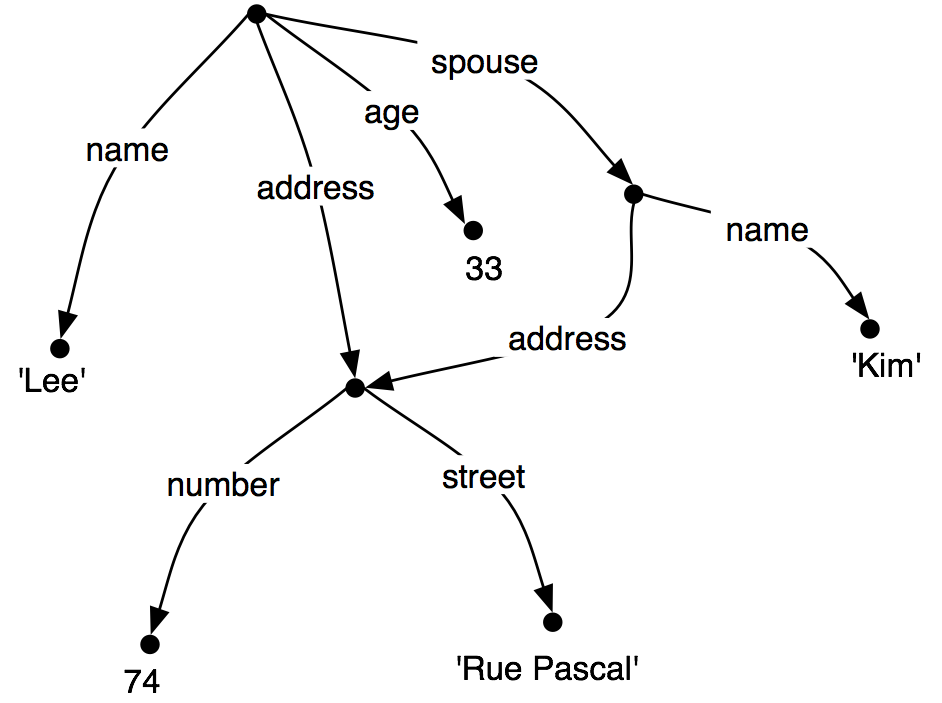


In [18]:
fs5 = nltk.FeatStruct("""
  [NAME = 'Lee', ADDRESS = (1) [NUMBER = 74, STREET = 'Rue Pascal'],
  SPOUSE = [Name = 'Kim', ADDRESS -> (1)]]
""")

print(fs5)

[ ADDRESS = (1) [ NUMBER = 74           ] ]
[               [ STREET = 'Rue Pascal' ] ]
[                                         ]
[ NAME    = 'Lee'                         ]
[                                         ]
[ SPOUSE  = [ ADDRESS -> (1)  ]           ]
[           [ Name    = 'Kim' ]           ]


## 2.1 Subsumption and Unificaton

### Subsumption

> Subsume (v): 1530s, from Modern Latin subsumere **"to take under,"** from Latin sub "under" (see sub-) + sumere "**to take, obtain, buy**," from sus‑, variant of sub‑ "up from under" + emere "to take" (from PIE root *em- "to take, distribute"). Related: Subsumed; subsuming, subsumption.

`FS_0` subsumes `FS_1` if all the information contained in `FS_0` is also contained in `FS_1`. We use the symbol `⊑` to represent subsumption. 

FS20 ⊑ FS22

Reentrancy makes this tricky. With reentrancy, if FS0 ⊑ FS1 then FS1 needs to have all the reentrancies and paths of FS0. 

The graph that is subsuming the other in a simple sense came before it, and provided the underlying structure that allowed the new edges and nodes to be added to, resulting in a "subsumed graph."

### Unfication

Unification is the combination of two graphs to yield a new graph that is subsumed by both the preceeding ones. It is in essence a merging of two graphs to yield a third graph. 

Some notes:
- Subsmumption and unification are connected such that a unified set is subsumed by both the individual constituent graphs that were unifed. 
  ```If FS0 ⊑ FS1 then FS0 ⊔ FS1 = FS1```
- If two graphs share the same edge but a different atom (also called node) then the unification results in a None on that edge. 
- Also works in reverse, if you add an atom to a common edge, then the atom is added to both the edges of the graph. 

> eg: you want to combine the following structures 

```
[NUMBER = 74          ]
[STREET = 'rue Pascal']
```

```
[CITY = Paris          ]
```

Into a third graph 

```
[NUMBER = 74          ]
[STREET = 'rue Pascal']
[CITY = 'Paris'       ]
```

You would use the unify operator.


In [4]:
fs1 = nltk.FeatStruct(NUMBER = 74, STREET = 'Ruse Pascal')
fs2 = nltk.FeatStruct(CITY = 'Paris')

print(fs1.unify(fs2))

# it is a symmetric operation
print(fs2.unify(fs1))

[ CITY   = 'Paris'       ]
[ NUMBER = 74            ]
[ STREET = 'Ruse Pascal' ]
[ CITY   = 'Paris'       ]
[ NUMBER = 74            ]
[ STREET = 'Ruse Pascal' ]


In [9]:
# adding a feature for the spouse only 

fs0 = nltk.FeatStruct("""[NAME=Lee,
                          ADDRESS=[NUMBER=74,
                                   STREET='rue Pascal'],
                          SPOUSE= [NAME=Kim,
                                   ADDRESS=[NUMBER=74,
                                            STREET='rue Pascal']]]""")
print(fs0)

print('\n----------------------------------------------------------\n')

fs1 = nltk.FeatStruct("""[SPOUSE = [ADDRESS = [CITY = 'Paris']]]
""")

print(fs0.unify(fs1))

[ ADDRESS = [ NUMBER = 74           ]               ]
[           [ STREET = 'rue Pascal' ]               ]
[                                                   ]
[ NAME    = 'Lee'                                   ]
[                                                   ]
[           [ ADDRESS = [ NUMBER = 74           ] ] ]
[ SPOUSE  = [           [ STREET = 'rue Pascal' ] ] ]
[           [                                     ] ]
[           [ NAME    = 'Kim'                     ] ]

----------------------------------------------------------

[ ADDRESS = [ NUMBER = 74           ]               ]
[           [ STREET = 'rue Pascal' ]               ]
[                                                   ]
[ NAME    = 'Lee'                                   ]
[                                                   ]
[           [           [ CITY   = 'Paris'      ] ] ]
[           [ ADDRESS = [ NUMBER = 74           ] ] ]
[ SPOUSE  = [           [ STREET = 'rue Pascal' ] ] ]
[           [        

In [10]:
fs2 = nltk.FeatStruct("""[NAME=Lee, ADDRESS=(1)[NUMBER=74, STREET='rue Pascal'],
                           SPOUSE=[NAME=Kim, ADDRESS->(1)]]""")
print(fs2.unify(fs1))

# thus in this case the reference of the object got updated, thus all edges that have a reentrancy to that referential object are updated 
# more generally if a common edge's atom is updated, all paths that are equivalent to that path are updated too. 

[               [ CITY   = 'Paris'      ] ]
[ ADDRESS = (1) [ NUMBER = 74           ] ]
[               [ STREET = 'rue Pascal' ] ]
[                                         ]
[ NAME    = 'Lee'                         ]
[                                         ]
[ SPOUSE  = [ ADDRESS -> (1)  ]           ]
[           [ NAME    = 'Kim' ]           ]


#3. Extending a feature based grammar 

## 3.1 Subcategorization

> Transitive verbs need an object to complete their action, while Intransitive verbs do not. 

eg: **I bring water.** "Bring" here is transitive because it needs an object to transfer it's action to. 
Whereas **I walk.** is intransitive because walk does not need an object to transfer its action. 

> Note: Some verbs function both ways. 
eg: She sang. She sang a song. 


So one problem we run into with using a CFG with attributes, is that a production of the type

```
VP -> IV
VP -> TV NP
```

doesnt let us say anything about verbs in general, even though IV and TV are both verbs. From the perspective of a CFG, they are just "atomic nonterminal symbols."

One way around this is to introduce the attribute of subcategorization, like so 

```
VP[TENSE=?t, NUM=?n] -> V[SUBCAT=intrans, TENSE=?t, NUM=?n]
VP[TENSE=?t, NUM=?n] -> V[SUBCAT=trans, TENSE=?t, NUM=?n] NP
VP[TENSE=?t, NUM=?n] -> V[SUBCAT=clause, TENSE=?t, NUM=?n] SBar
```

This is called **Generalized Phrase Structure Grammar** or GPSG. 
As you can see the "subcat" is not added to the VP but to the V because the subcat is a pointer to a production in which `V[subcat = trans]` is introduced as the head element. The head element modifies the the subsequent elements. 

Another way of subcategorizing is through a framework known as categorical grammar. The subcat values encode the valency of a head (the list of arguments that it can combine with)

It would look something like so
``` 
V[SUBCAT = <NP, Np, PP>]
```

which means that the first `NP` is the subject of the lexical head, while the following elements comprise the subcategorized-for compliments. 

A traditional VP production rule looks so:
```
VP -> V NP # tradtional production rule

V[SUBCAT = <NP>]

```

## 3.2 Heads Revisited

- V (verbs) are heads of phrases of category VP. 
- Ns are heads of phrases of category NP
- Ps are heads of phrases of category PP

Not all phrases need to have heads, for example coordinate phrases (the book adn the ball) does not have a head. 

X-Bar Syntax is a way of building up the grammar, where typically 3 levels are used to build up from a lexical level (level = 0) to a phrasal level (level = 2).

- Lexical level N is called zero projection 
- N" (level = 2) is clled the maximal projection
- N' (level = 1) is typicalled called Nominative (nom) which is a grouping of nouns or adjectives with similar characteristics. 

Features of X-Bar grammar:
- The purpose of this representation is so that all constituents share a similar structure. 
- subcategorized complements (what matches their valency) are placed as siblings on the head 
- adjuncts (that can add information and can be removed without affecting the structure of the sentence) are placed as siblings of an intermediate category.  


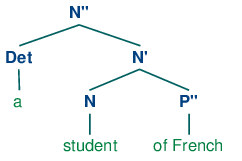 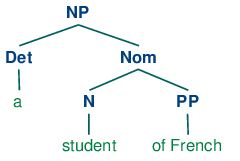

## X-BAR grammar

```
S -> N[BAR=2] V[BAR=2]
N[BAR=2] -> Det N[BAR=1]
N[BAR=1] -> N[BAR=1] P[BAR=2]
N[BAR=1] -> N[BAR=0] P[BAR=2]
N[BAR=1] -> N[BAR=0]XS
```

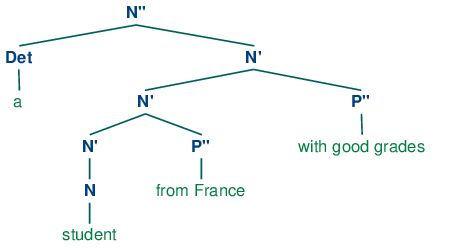